This notebook was adapted from David Shean's tutorial on pulling SNOTEL data (located here: )

In [1]:
# this is the CUAHSI API endpoint
# http://his.cuahsi.org/wofws.html
wsdlurl = 'https://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL'

In [2]:
#Install directly from github repo main branch
#%pip install -q git+https://github.com/ulmo-dev/ulmo.git
import ulmo

In [3]:
# import packages, had some issues importing/installing geopandas and contextily, but got it eventually

import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx


In [4]:
# identify SNOTEL site locations
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [5]:
# preview an item in the dictionary to see what we pulled
next(iter(sites.items()))

('SNOTEL:301_CA_SNTL',
 {'code': '301_CA_SNTL',
  'name': 'Adin Mtn',
  'network': 'SNOTEL',
  'location': {'latitude': '41.2358283996582',
   'longitude': '-120.79192352294922'},
  'elevation_m': '1886.7120361328125',
  'site_property': {'county': 'Modoc',
   'state': 'California',
   'site_comments': 'beginDate=10/1/1983 12:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=180200021403|HUD=18020002|TimeZone=-8.0|actonId=20H13S|shefId=ADMC1|stationTriplet=301:CA:SNTL|isActive=True',
   'pos_accuracy_m': '0'}})

In [6]:
# convert to pandas dataframe from dictionary and drop na values
sites_df = pd.DataFrame.from_dict(sites, orient='index').dropna()

In [7]:
# clean up dataframe and prepare point geometry objects, need x and y locs
# do this by creating a new column (geometry) and pulling lat and long info and use Point package to pull info from dict
sites_df['geometry']=[Point(float(loc['longitude']),float(loc['latitude'])) for loc in sites_df['location']]
sites_df = sites_df.drop(columns='location')
sites_df = sites_df.astype({'elevation_m':float})

In [8]:
# gathers all snotel sites
sites_gdf_all = gpd.GeoDataFrame(sites_df, crs='EPSG:4326')
# gathers all snotel sites in Washington and Oregon
searchfor = ['WA','OR']
sites_gdf_orwa = sites_gdf_all[sites_gdf_all.index.str.contains('|'.join(searchfor))]

In [23]:
# nearby sites are shown as the value of each key pair
# fire locations
fire_sites = {'Sentinel Butte':'Gold Axe Camp',
              'Grouse Camp':'Trough',
              'Harts Pass':'Rainy Pass',
              'Three Creeks Meadow': 'Irish Taylor',
              'Pope Ridge': 'Trinity'}
# logging locations
logging_sites = {'Seine Creek':'Saddle Mountain',
                 'Mowich':'Burnt Mountain'}

In [24]:
snotel_fires = sites_gdf_orwa[sites_gdf_orwa['name'].isin(fire_sites.keys())]
snotel_logging = sites_gdf_orwa[sites_gdf_orwa['name'].isin(logging_sites.keys())]

In [25]:
fire_codes = {}
for i in fire_sites:
    fire_codes[i] = snotel_fires['name'].loc[lambda x: x== i].index.tolist()[0]

In [26]:
logging_codes = {}
for i in logging_codes:
    logging_codes[i] = snotel_logging['name'].loc[lambda x: x== i].index.tolist()[0]

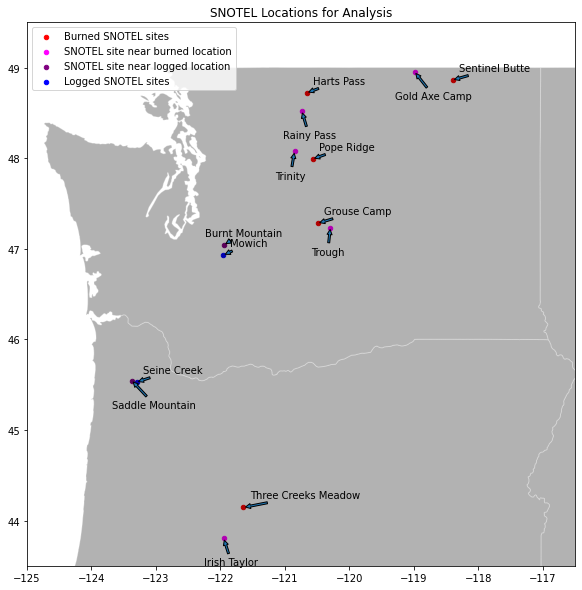

In [27]:
#geojson of state polygons
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

snotel_fires = sites_gdf_orwa[sites_gdf_orwa['name'].isin(list(fire_sites.keys()))]
snotel_fire_nearby = sites_gdf_orwa[sites_gdf_orwa['name'].isin(list(fire_sites.values()))]
snotel_logging = sites_gdf_orwa[sites_gdf_orwa['name'].isin(list(logging_sites.keys()))]
snotel_logging_nearby = sites_gdf_orwa[sites_gdf_orwa['name'].isin(list(logging_sites.values()))]

f, ax = plt.subplots(figsize=(15,10))
snotel_fires.plot(ax=ax,  markersize=20, color='red', label='Burned SNOTEL sites')
snotel_fire_nearby.plot(ax=ax,  markersize=20, color='magenta', label='SNOTEL site near burned location')
snotel_logging_nearby.plot(ax=ax,  markersize=20, color='purple', label='SNOTEL site near logged location')
snotel_logging.plot(ax=ax,  markersize=20, color='blue', label='Logged SNOTEL sites')
for site in snotel_fires.index:
    plt.annotate(snotel_fires.loc[site]['name'],
                xy = ((snotel_fires.loc[site].geometry.x,snotel_fires.loc[site].geometry.y)),
                xytext=(snotel_fires.loc[site].geometry.x+0.1,snotel_fires.loc[site].geometry.y+0.1),
                arrowprops={'arrowstyle':'simple'})
for site in snotel_fire_nearby.index:
    plt.annotate(snotel_fire_nearby.loc[site]['name'],
                xy = ((snotel_fire_nearby.loc[site].geometry.x,snotel_fire_nearby.loc[site].geometry.y)),
                xytext=(snotel_fire_nearby.loc[site].geometry.x-0.3,snotel_fire_nearby.loc[site].geometry.y-0.3),
                arrowprops={'arrowstyle':'simple'})
for site in snotel_logging.index:
    plt.annotate(snotel_logging.loc[site]['name'],
                xy = ((snotel_logging.loc[site].geometry.x,snotel_logging.loc[site].geometry.y)),
                xytext=(snotel_logging.loc[site].geometry.x+0.1,snotel_logging.loc[site].geometry.y+0.1),
                arrowprops={'arrowstyle':'simple'})
for site in snotel_logging_nearby.index:
    if snotel_logging_nearby.loc[site]['name'] == 'Burnt Mountain':
       plt.annotate(snotel_logging_nearby.loc[site]['name'],
                xy = ((snotel_logging_nearby.loc[site].geometry.x,snotel_logging_nearby.loc[site].geometry.y)),
                xytext=(snotel_logging_nearby.loc[site].geometry.x-0.3,snotel_logging_nearby.loc[site].geometry.y+0.1),
                arrowprops={'arrowstyle':'simple'})
    else: 
        plt.annotate(snotel_logging_nearby.loc[site]['name'],
                    xy = ((snotel_logging_nearby.loc[site].geometry.x,snotel_logging_nearby.loc[site].geometry.y)),
                    xytext=(snotel_logging_nearby.loc[site].geometry.x-0.3,snotel_logging_nearby.loc[site].geometry.y-0.3),
                    arrowprops={'arrowstyle':'simple'})
ax.autoscale(False)
states_gdf.plot(ax=ax, facecolor='k', edgecolor='white', alpha=0.3)
plt.xlim(-125,-116.5)
plt.ylim(43.5,49.5)
plt.legend(loc='upper left')
plt.title('SNOTEL Locations for Analysis')
outpath = r'C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data'
plt.savefig(outpath)

In [17]:
# import for interactive visualizations
import hvplot.pandas
from geoviews import tile_sources as gvts

In [16]:
# geojson of state polygons for later visualization
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
states_gdf = gpd.read_file(states_url)

In [22]:
# makes nice figure of snotel locations with esri map 
sites = sites_gdf_orwa
map_tiles = gvts.EsriImagery
map_tiles * sites.to_crs('EPSG:3857').hvplot(hover_cols=['index','name','elevation_m']) * states_gdf.to_crs('EPSG:3857').hvplot(color='none')

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Points.I   :Points   [x,y]   (index,name,elevation_m)
   .Polygons.I :Polygons   [x,y]

In [28]:
# snow and swe variables
met_vars = ['SNOTEL:SNWD_D','SNOTEL:WTEQ_D']

today = datetime.today().strftime('%Y-%m-%d')
# function will take in a sitecode, variable code, start and end date and return variable data for that range and location as df
def snotel_fetch(sitecode, variablecode, start_date='1950-01-01', end_date=today):
    values_df = None
    try:
        # start by requesting data from the server
        print('Requesting Data from Server...')
        
        site_values = ulmo.cuahsi.wof.get_values(wsdlurl,sitecode, variablecode, start=start_date, end=end_date)
        # convert to pandas dataframe
        values_df = pd.DataFrame.from_dict(site_values['values'])
        # parse the datetime values to Pandas Timestamp object
        print('Cleaning Data...')
        values_df['datetime'] = pd.to_datetime(values_df['datetime'], utc=False)
        # set df index to datetime
        values_df = values_df.set_index('datetime')
        # convert values to float and replace -9999 with NaN
        values_df['value'] = pd.to_numeric(values_df['value']).replace(-9999,np.nan)
        # rename values column after variable code
        values_df.rename(columns = {'value':variablecode}, inplace = True)
        # remove lower quality records
        values_df = values_df[values_df['quality_control_level_code']=='1']
        print('Done!')
    except:
        print('Unable to fetch %s' % variablecode)
    return values_df

In [29]:
def getStation_output(outpath ,fname, sitecode, start='1950-01-01', end=today, variables=met_vars):
    output = []
    for var in variables:
        if var == 'SNOTEL:SNWD_D':
            name = fname+'_depth'
        elif var == 'SNOTEL:WTEQ_D':
            name = fname+'_swe'
        print('Fetching {0} for {1}'.format(var, sitecode))
        variable_code = var # 0 for depth, 1 for swe
        site_snotel = snotel_fetch(sitecode, variable_code,start_date=start,end_date=end)
        # site_snotel.to_excel(os.path.join(outpath,name+'.xlsx'))
        # print('Produced excel located here {0}'.format(os.path.join(outpath,name+'.xlsx')))
        site_snotel.to_csv(os.path.join(outpath,name+'.csv')) 
        print('Produced excel located here {0}'.format(os.path.join(outpath,name+'.csv')))
        output.append(site_snotel)
    return tuple(output)


In [31]:
snotel_outputs = {}
import contextlib
locs = [snotel_fires,snotel_fire_nearby,snotel_logging,snotel_logging_nearby]
outpath = r'C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565_project\data'
#with contextlib.redirect_stdout(None): all printing the same values
for site_type in locs:
    for station in site_type.index:
        fname = site_type.loc[station]['name']
        #start, end = '2017-10-01', '2018-09-30' # change dates if desired
        tmp, sitename = getStation_output(outpath, fname, station)
        if (tmp is not None):
            snotel_outputs[fname] = tmp
        else:
            print('Skipping %s - no data available' %station)

Fetching SNOTEL:SNWD_D for SNOTEL:507_WA_SNTL
Requesting Data from Server...
Cleaning Data...
Done!
Produced excel located here C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data\Grouse Camp_depth.csv
Fetching SNOTEL:WTEQ_D for SNOTEL:507_WA_SNTL
Requesting Data from Server...
Cleaning Data...
Done!
Produced excel located here C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data\Grouse Camp_swe.csv
Fetching SNOTEL:SNWD_D for SNOTEL:515_WA_SNTL
Requesting Data from Server...
Cleaning Data...
Done!
Produced excel located here C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data\Harts Pass_depth.csv
Fetching SNOTEL:WTEQ_D for SNOTEL:515_WA_SNTL
Requesting Data from Server...
Cleaning Data...
Done!
Produced excel located here C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data\Harts Pass_swe.csv
Fetching SNOTEL:SNWD_D for SNOTEL:699_WA_SNTL
Requesting Data from Server...
Cleaning Data...
Done!
Produc

In [195]:
import os
def plotSWE(ax, site_name, variable, folder):
    filename = site_name+'_'+variable+'.csv'
    filepath = os.path.join(folder,filename)
    if variable == 'depth':
        var = 'SNOTEL:SNWD:D'
    elif variable == 'swe':
        var = 'SNOTEL:WTEQ_D'
    df = pd.read_csv(filepath)
    df['datetime'] = pd.to_datetime(df['datetime'])
    bins = 10
    ax.hist(df[var]*2.54, bins, label = site_name, ec='k',alpha=0.5)
    ax.set_ylabel('occurances')
    ax.set_xlabel('{} [cm]'.format(variable))
    ax.legend()
    return

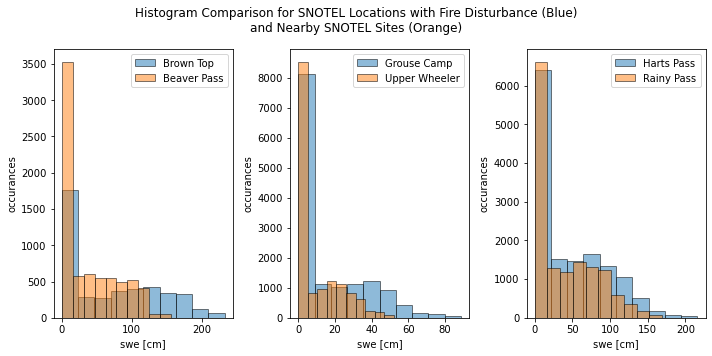

In [206]:
fig, axs = plt.subplots(ncols=len(fire_sites), figsize=(10,5), tight_layout=True)
fig.suptitle('Histogram Comparison for SNOTEL Locations with Fire Disturbance (Blue)\nand Nearby SNOTEL Sites (Orange)')
for i,site in enumerate(fire_sites.keys()):
    plotSWE(ax = axs[i], site_name = site, variable = 'swe', folder = r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data")
    plotSWE(ax = axs[i], site_name = fire_sites[site], variable = 'swe', folder = r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data")
fig.savefig(r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\fire_swe_comparison.png")

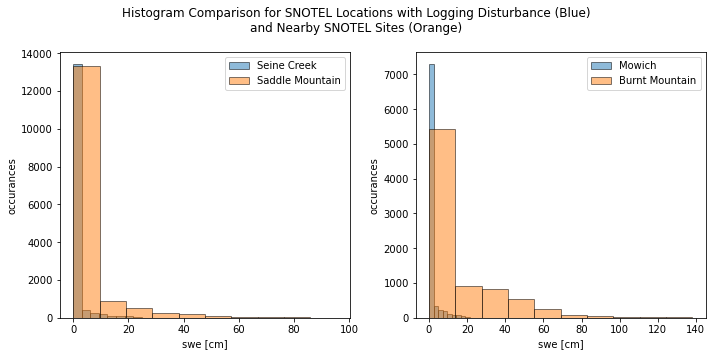

In [205]:
fig, axs = plt.subplots(ncols=len(logging_sites), figsize=(10,5), tight_layout=True)
fig.suptitle('Histogram Comparison for SNOTEL Locations with Logging Disturbance (Blue)\nand Nearby SNOTEL Sites (Orange)')
for i,site in enumerate(logging_sites.keys()):
    plotSWE(ax = axs[i], site_name = site, variable = 'swe', folder = r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data")
    plotSWE(ax = axs[i], site_name = logging_sites[site], variable = 'swe', folder = r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data")
fig.savefig(r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\logging_swe_comparison.png")

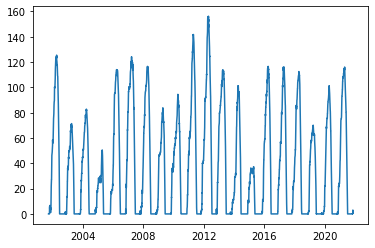

In [126]:
# location = os.path.basename(filepath)
df = pd.read_csv(r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data\Beaver Pass_swe.csv")

plt.plot(df['datetime'],df['SNOTEL:WTEQ_D']*2.54)
# plt.xlabel('time')
# plt.ylabel('{} [cm]'.format('SNOTEL:WTEQ_D'))
# plt.title(location[0:-4])

In [ ]:
plotSWE(r"C:\Users\dlhogan\OneDrive - UW\Documents\GitHub\CEWA565\Final-Project\data\Beaver Pass_swe.csv", 'SNOTEL:WTEQ_D')